## Primeras pruebas con los datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Ruta del archivo donde estan las funciones e importarlo
sys.path.append(os.path.abspath('../'))
from utils.eda_functions import *

#### 1. Definición del problema, carga de datos y  visualización.

Ver si a partir de los diferentes datos de pacientes, se puede predecir mediante un modelo si estos tienen Alzheimer o no. Esto podría ser de ayuda para los profesionales de la salud, a modo de cribaje, soporte...

In [2]:
# Se carga el dataframe inicial que se ha descargado de Kaggle con la información
route = "../data_sample/alzheimers_disease_data.csv"
df_alzheimer = pd.read_csv(route)

# Se hace una pequeña visualización del df
print("Primeras cinco líneas del dataset que corresponden con los cinco primeros pacientes.")
df_alzheimer.head()

Primeras cinco líneas del dataset que corresponden con los cinco primeros pacientes.


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
# Se hace una exploración inicial del df:

print(f"El dataset tiene {df_alzheimer.shape[0]} filas/pacientes y {df_alzheimer.shape[1]} columnas de información sobre el Alzheimer.")

print(f"Hay {df_alzheimer[df_alzheimer.Diagnosis == 0].shape[0]} pacientes sanos y {df_alzheimer[df_alzheimer.Diagnosis == 1].shape[0]} pacientes diagnosticados de Alzheimer.")

print("\nInformación general de las columnas del dataset:\n")
df_alzheimer.info()

El dataset tiene 2149 filas/pacientes y 35 columnas de información sobre el Alzheimer.
Hay 1389 pacientes sanos y 760 pacientes diagnosticados de Alzheimer.

Información general de las columnas del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQua

In [4]:
# Cálculo de la cardinalidad de la primera columna
car_id = cardinalidad(df_alzheimer["PatientID"], df_alzheimer)
print(f"La cardinalidad de la columna que recoge los índices es del {car_id}%")

La cardinalidad de la columna que recoge los índices es del 100.0%


**Target**

Observar si está balanceado o no.

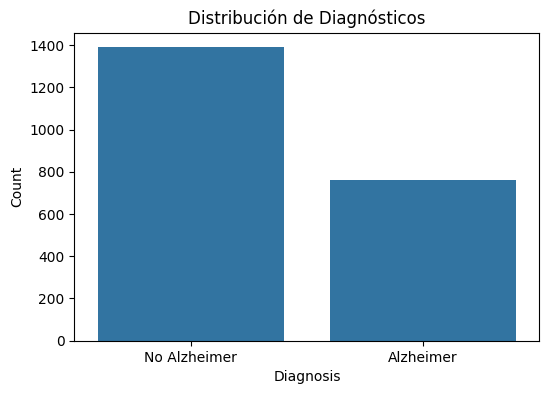

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x=df_alzheimer["Diagnosis"])

plt.title("Distribución de Diagnósticos")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.xticks([0, 1], ["No Alzheimer", "Alzheimer"])
plt.show()

In [6]:
df_alzheimer["Diagnosis"].value_counts(normalize=True)

Diagnosis
0    0.646347
1    0.353653
Name: proportion, dtype: float64

**Comentarios**

* Hay 2149 filas que corresponden con los pacientes incluidos en el dataset. 

* De cada uno de ellos hay 34 columnas con información. 

* La primera columna, PatientID, puede usarse de índice debido a su cardinalidad del 100%. También deja claro que no habrá duplicado ningún paciente.

* Todas las columnas son numéricas menos la última, de tipo int64 y float64. 

* En niguna de ella faltan datos.

* El target está desbalanceado y habrá que tenerlo en cuenta en las métricas de los modelos.

#### 2. Observar los tipos de features

Factores demográficos:

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| PatientID       | int64 | Índice del paciente |
| Age       | int64 | Edad del paciente |
| Gender       | int64 | Género del paciente, 0 o 1 |
| Ethnicity       | int64 | Etnia del paciente, 0: caucásico, 1: Afroamericano, 2: asiático, 3: Otros |
| EducationLevel       | int64 | Nivel educacional del paciente, 0: Ninguno, 1: Escuela secundaria, 2: Licenciatura, 3: Superior |

Factores lifestyle:

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| BMI       | float64 | Índice de masa corporal del paciente, entre 15-40 |
| Smoking       | int64 | Si el paciente fuma o no, binario |
| AlcoholConsumption       | float64 | Consumo de alcohol semanal en unidades del paciente, 0-20 |
| PhysicalActivity       | float64 | Actividad física en horas del paciente, 0-10 |
| DietQuality       | float64 | Calidad de la dieta del paciente, 0-10 |
| SleepQuality       | float64 | Calidad del sueño del paciente, 4-10 |

Historial médico:

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| FamilyHistoryAlzheimers       | int64 | Si el paciente tiene antecedentes familiares de Alzheimer, binario |
| CardiovascularDisease       | int64 | Si el paciente tiene problemas cardiovasculares, binario |
| Diabetes       | int64 | Si el paciente tiene diabetes, binario |
| Depression       | int64 | Si el paciente tiene depresión o no, binario |
| HeadInjury       | int64 | Si el paciente tuvo traumatismo craneal o no, binario |
| Hypertension       | int64 | Si el paciente tiene hipertensión o no, binario |

Mediciones clínicas:

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| SystolicBP       | int64 | Presión arterial sistólica del paciente, 90-180 mmHg. |
| DiastolicBP       | int64 | Presión arterial diastólica del paciente, 60-120 mmHg. |
| CholesterolTotal       | float64 | Niveles de colesterol total del paciente, 150-300 mg/dL. |
| CholesterolLDL       | float64 | Niveles de colesterol lipoproteínas de baja densidad, 50-200 mg/dL. |
| CholesterolHDL      | float64 | Niveles de colesterol lipoproteínas de alta densidad, 20-100 mg/dL |
| CholesterolTriglycerides       | float64 | Niveles de triglicéridos del paciente, 50-400 mg/dL. |

Evaluaciones cognitivas y funcionales:

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| MMSE       | float64 | Puntuación del Mini-Examen del Estado Mental, 0-30. |
| FunctionalAssessment       | float64 | Puntuación de evaluación funcional, 0-10 |
| MemoryComplaints       | int64 | Quejas de memoria del paciente, binario. |
| BehavioralProblems       | int64 | Problemas de conducta del paciente, binario. |
| ADL       | float64 |  Puntuación de actividades de la vida diaria, 0-10. |

Síntomas:

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| Confusion       | int64 | Problemas de conducta del paciente, binario. |
| Disorientation       | int64 | Desorientación del paciente, binario. |
| PersonalityChanges       | int64 | Cambios de personalidad del paciente, binario. |
| DifficultyCompletingTasks       | int64 | Dificultad en completar tareas del paciente, binario. |
| Forgetfulness       | int64 | Olvido del paciente, binario. |

Diagnóstico: 

| **Variable** | **Tipo** | **Descripción** |
| ---------------- | --------------- | ----------- |
| Diagnosis       | int64 | Diagnóstico de Alzheimer del paciente, binario. Target |
| DoctorInCharge       | object | Información del médico, es confidencial. |

In [7]:
df_alzheimer.nunique()

PatientID                    2149
Age                            31
Gender                          2
Ethnicity                       4
EducationLevel                  4
BMI                          2149
Smoking                         2
AlcoholConsumption           2149
PhysicalActivity             2149
DietQuality                  2149
SleepQuality                 2149
FamilyHistoryAlzheimers         2
CardiovascularDisease           2
Diabetes                        2
Depression                      2
HeadInjury                      2
Hypertension                    2
SystolicBP                     90
DiastolicBP                    60
CholesterolTotal             2149
CholesterolLDL               2149
CholesterolHDL               2149
CholesterolTriglycerides     2149
MMSE                         2149
FunctionalAssessment         2149
MemoryComplaints                2
BehavioralProblems              2
ADL                          2149
Confusion                       2
Disorientation

#### 3. Limpieza de columnas, nulos y duplicados

**Missings**

En este caso, como se ha visto con la información previamente, no hay nulos en ninguna columna. En el caso de que hubiera habido, habría que ver en qué proporción y cómo solucionarlo según esto: eliminarlos, transformarlos mediante otros valores (media, moda, mediana, etc)...

**Duplicados**

Como se había supuesto al enseñar la cardinalidad de los índices, no hay pacientes duplicados duplicados. En el caso de que hubiera, se deberían eliminar mediante `drop_duplicates()`.

In [8]:
df_alzheimer.loc[df_alzheimer.duplicated()]

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge


**Índice y drop**

Poner el índice que corresponde y eliminar la columna que no necesitamos.

In [9]:
df_alzheimer.set_index("PatientID", inplace = True)

df_alzheimer.drop(columns = ["DoctorInCharge"], inplace = True)

print(f"El nuevo número de columnas es {df_alzheimer.shape[1]}")


El nuevo número de columnas es 33


**Transformaciones**

Como no se va a profundizar tanto, se va a transformar la presión arterial sistólica y diastólica en una única variable, presión arterial media (MAP). Esto es posible ya que siguen la siguiente fórmula:

$$
MAP = \frac{P_{sistólica} + 2 \cdot P_{diastólica}}{3} mmHg
$$

In [10]:
df_alzheimer["MAP"] = (df_alzheimer["SystolicBP"] + (2*df_alzheimer["DiastolicBP"]))/3
df_alzheimer.drop(columns = ["SystolicBP", "DiastolicBP"], inplace = True)
print(f"El nuevo número de columnas es {df_alzheimer.shape[1]}")

El nuevo número de columnas es 32


In [11]:
df_alzheimer.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,MAP
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,95.333333
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,81.000000
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,110.333333
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,116.000000
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,109.333333


**Distribuciones**

Se observan el describe de las numéricas para ver si en alguna hay que hacer hincapié y detectar outliers (aplicar logaritmos, etc.)

In [12]:
df_alzheimer.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,0.288506,0.453173,0.000000,0.000000,0.000000,1.000000,1.000000
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346
SleepQuality,2149.0,7.051081,1.763573,4.002629,5.482997,7.115646,8.562521,9.999840


**Tratamiento de features numéricas**

Las variables numéricas han de ser escaladas para el mejor funcionamiento de algunos modelos, y aunque no hay outliers, evitar los posibles efectos de valores extremos.

In [13]:
# Definir las columnas binarias - no se escalan
binary_cols = ["Gender", "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease", 
               "Diabetes", "Depression", "HeadInjury", "Hypertension", "MemoryComplaints", 
               "BehavioralProblems", "Confusion", "Disorientation", "PersonalityChanges", 
               "DifficultyCompletingTasks", "Forgetfulness", "Diagnosis"]

# Seleccionar las columnas numéricas (que no son las binarias)
numeric_cols = df_alzheimer.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col not in binary_cols]

# Escalado
scaler = StandardScaler()
df_alzheimer[numeric_cols] = scaler.fit_transform(df_alzheimer[numeric_cols])


**Tratamiento de features categóricas**

Las variables de etnia y nivel educativo tienen 4 valores diferentes, por lo que hacemos one-hot encoding, ya que los modelos lineales lo necesitan.

In [14]:
# Seleccionar columnas
categorical_cols = ["Ethnicity", "EducationLevel"]

# Aplicar One-Hot Encoding 
df_alzheimer = pd.get_dummies(df_alzheimer, columns=categorical_cols, drop_first=True)

#### 4. División de datos en train/test

En proporción 80% train y 20% test.

In [15]:
X = df_alzheimer.drop(columns=["Diagnosis"])  # quitando el target
y = df_alzheimer["Diagnosis"]  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 5. Entrenamiento de modelos base

**Métricas**

Como se está detectando el diagnóstico de una enfermedad (no queremos que hayan falsos negativos) y además tenemos el target algo desbalanceado, se van a utilizar las siguientes métricas:

* F1-Score: Se usa porque combina precisión y recall, útil en datos desbalanceados.
* Recall: Se enfoca en minimizar los falsos negativos, importante para detectar la enfermedad correctamente.

**Modelos**

Los seis modelos que se van a probar como base son:

* Logistic Regression (LR): Modelo lineal simple que funciona bien en datasets con relaciones directas entre variables y el target.
* Random Forest (RF): Algoritmo de ensamble basado en árboles, robusto y bueno para capturar relaciones no lineales.
* Support Vector Machine (SVM): Funciona bien en espacios de alta dimensión y es eficaz con datos no lineales.
* K-Nearest Neighbors (KNN): Basado en proximidad de datos, útil cuando no hay una estructura clara.
* XGBoost: Modelo basado en boosting, potente para problemas complejos y mejora el rendimiento minimizando errores de modelos anteriores.
* LightGBM: Variante de boosting optimizada para eficiencia y velocidad en datasets grandes.

In [16]:
# Modelos base en un diccionario
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier()
}

# Entrenar y evaluar modelos
results = []

for name, model in models.items():
    
    # entrenamiento
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # metricas
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results.append((name, f1, recall))

    # Mostrar classification report
    print(f"\nClassification Report para {name}:\n")
    print(classification_report(y_test, y_pred))

# Resultados en df y ordenar por f1
results_df = pd.DataFrame(results, columns=["Model", "F1-Score", "Recall"])
results_df = results_df.sort_values(by="F1-Score", ascending=False)

# Resultados
print("\nResultados de los modelos base:")
print(results_df)

# Guardar los tres mejores
top_3_models = results_df.head(3)


Classification Report para Logistic Regression:

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       278
           1       0.75      0.76      0.75       152

    accuracy                           0.83       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.83      0.83      0.83       430


Classification Report para Random Forest:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.90      0.92       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430


Classification Report para SVM:

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       278
           1       0.83      0.71      0.77       152

    accuracy                           0.85       430


#### 6. Definición de hiperparámetros

Buscar mediante GridSearch los mejores hiperparámetros de los tres mejores modelos obtenidos previamente para ver cuanto pueden mejorar.


In [17]:
# Definir los hiperparámetros en un diccionario
param_grid = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 10]
    },
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [-1, 10, 20]
    }
}

In [18]:
best_models = {}
best_params = {}

for model_name, model in zip(["Random Forest", "XGBoost", "LightGBM"], 
                             [RandomForestClassifier(), 
                              xgb.XGBClassifier(use_label_encoder = False, eval_metric='logloss'), 
                              lgb.LGBMClassifier()]):

    grid_search = GridSearchCV(model, param_grid[model_name], 
                               scoring="recall", cv=5, verbose=1, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    # Guardar el mejor modelo y sus hiperparámetros
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    
    print(f"\nMejor configuración para {model_name}: {grid_search.best_params_}")
    print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Mejor configuración para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

Mejor F1-score en validación cruzada: 0.8636363636363636
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:12:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Mejor configuración para XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Mejor F1-score en validación cruzada: 0.9128979813033464
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

**Resultados**

* LightGBM

In [19]:
best_lgb = lgb.LGBMClassifier(**best_params['LightGBM'])
best_lgb.fit(X_train, y_train)
y_pred_lgb = best_lgb.predict(X_test)

print("LightGBM - Classification Report")
print(classification_report(y_test, y_pred_lgb))
print(f"F1 Score: {f1_score(y_test, y_pred_lgb)}")


[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

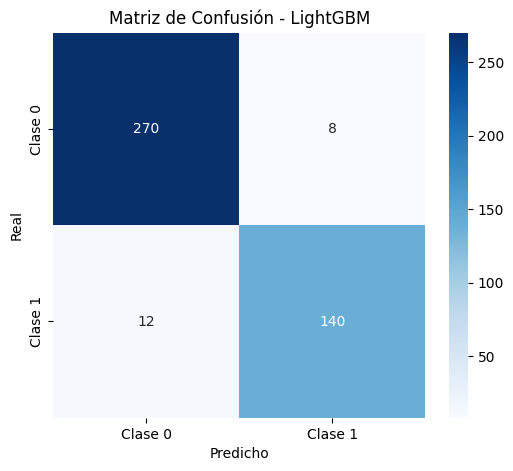

In [25]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

plot_confusion_matrix(y_test, y_pred_lgb, "LightGBM")

* XGBoost

In [21]:
best_xgb = xgb.XGBClassifier(**best_params['XGBoost'])
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost - Classification Report")
print(classification_report(y_test, y_pred_xgb))
print(f"F1 Score: {f1_score(y_test, y_pred_xgb)}")


XGBoost - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       278
           1       0.93      0.91      0.92       152

    accuracy                           0.94       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.94      0.94      0.94       430

F1 Score: 0.9205298013245033


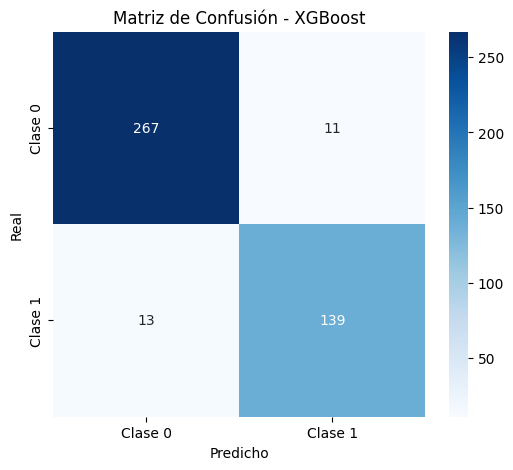

In [26]:
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

* Random Forest

In [23]:
best_rf = RandomForestClassifier(**best_params['Random Forest'])
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       278
           1       0.94      0.89      0.92       152

    accuracy                           0.94       430
   macro avg       0.94      0.93      0.94       430
weighted avg       0.94      0.94      0.94       430

F1 Score: 0.918918918918919


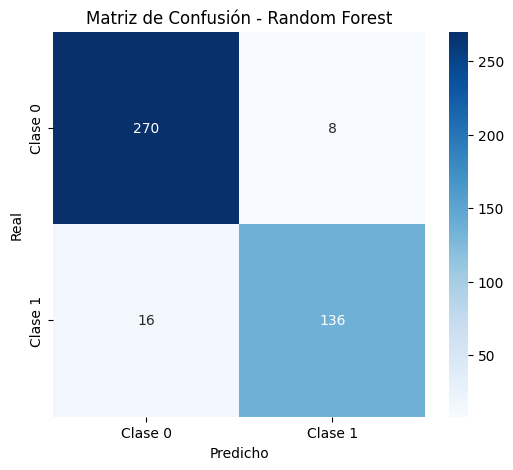

In [27]:
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

#### 7. Feature selection

**A través de Random Forest**

In [31]:
# Emtrenar el modelo de RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# feature importance
feature_importances = rf.feature_importances_

# features por encima del umbral y crear los conjuntos de datos
threshold = 0.025
selected_features = X_train.columns[feature_importances > threshold]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"{len(selected_features)} Características seleccionadas: {list(selected_features)}")

16 Características seleccionadas: ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'MAP']


C:\Users\tebar\AppData\Local\Temp\ipykernel_19872\1117145981.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp_df, x="Importance", y="Feature", palette="viridis")


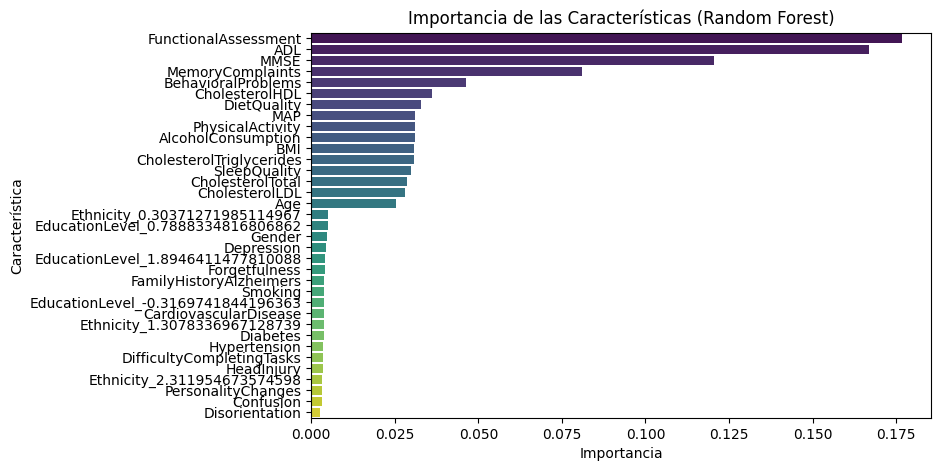

In [32]:
feature_imp_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})
feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_imp_df, x="Importance", y="Feature", palette="viridis")

plt.title("Importancia de las Características (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

Entrenar los tres mejores modelos con las features seleccionadas.

[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3279
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
LightGBM - F1 Score: 0.9333


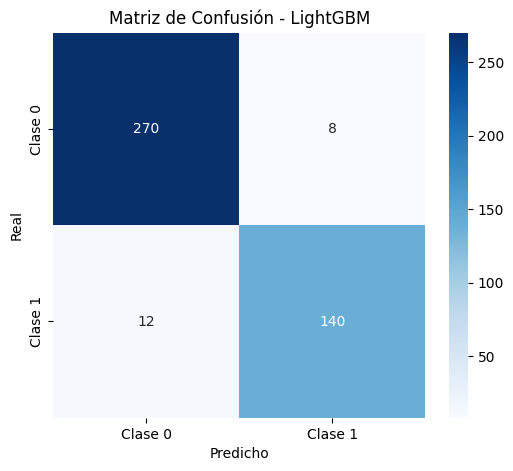

XGBoost - F1 Score: 0.9231


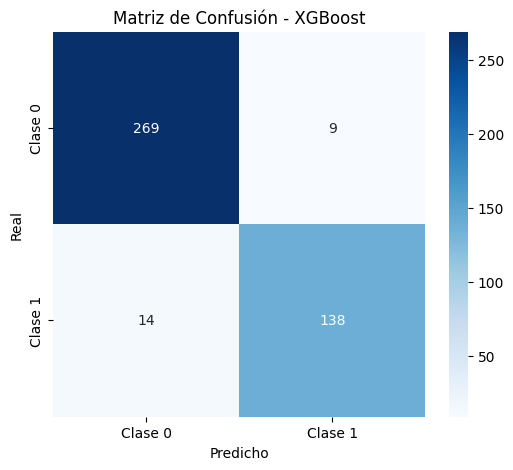

Random Forest - F1 Score: 0.9298


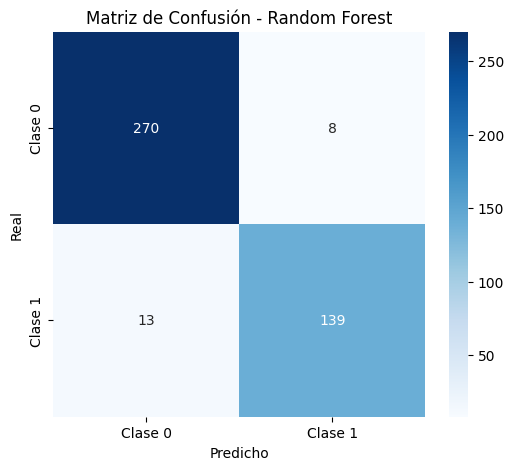

In [ ]:
# Entrenar modelos con estas características
models = {
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print(f"{name} - F1 Score: {f1_score(y_test, y_pred)}")

    plot_confusion_matrix(y_test, y_pred, name)

**Mejores hiperparámetros**

Aplicar los mejores hiperparámetros que se habían obtenido antes al feature selection.

[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3279
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
LightGBM - F1 Score: 0.9333


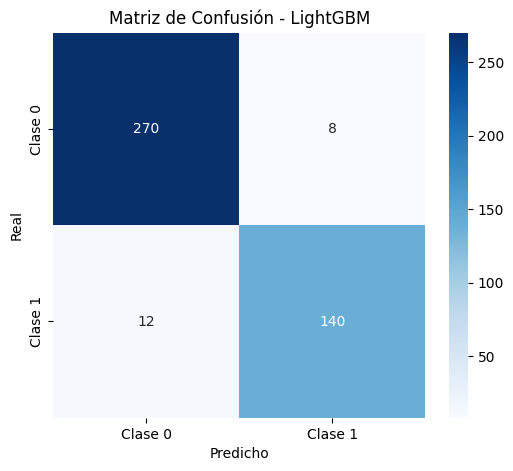

XGBoost - F1 Score: 0.9231


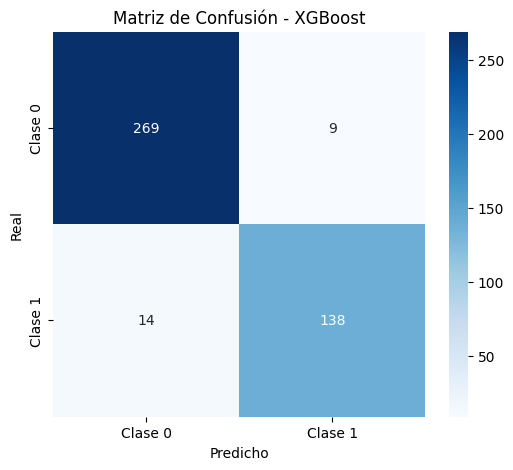

Random Forest - F1 Score: 0.9333


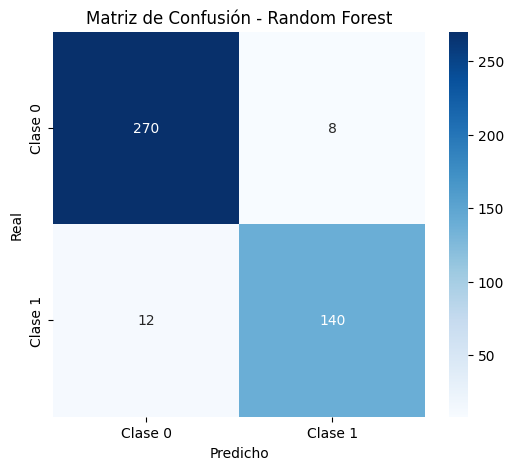

In [ ]:
best_models = {
    "LightGBM": best_lgb,
    "XGBoost": best_xgb,
    "Random Forest": best_rf
}

# Entrenar modelos con estos hiperparametros
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print(f"{name} - F1 Score: {f1_score(y_test, y_pred)}")
    
    plot_confusion_matrix(y_test, y_pred, name)

**A través de PCA**

In [30]:
# Número de componentes principales a retener 
pca = PCA(n_components=0.95)  # 95% de la varianza
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Número de componentes principales seleccionados: {pca.n_components_}")

Número de componentes principales seleccionados: 27


Entrenar los tres mejores modelos con las features seleccionadas.

c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841


c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - F1 Score: 0.7194244604316546


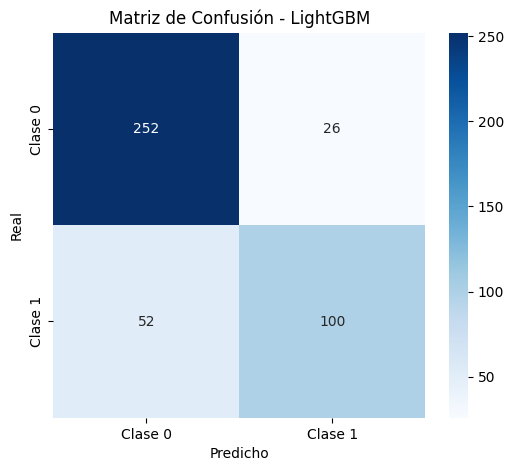

XGBoost - F1 Score: 0.6959706959706959


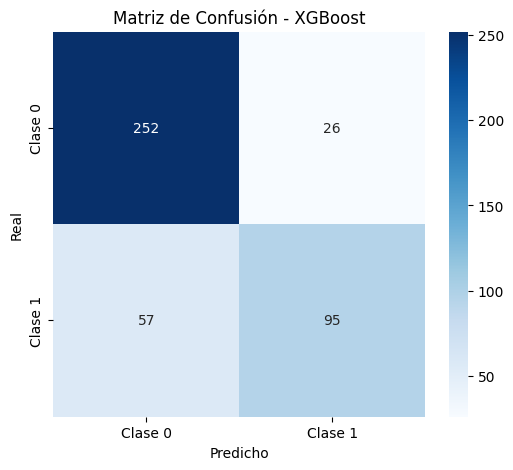

Random Forest - F1 Score: 0.6324110671936759


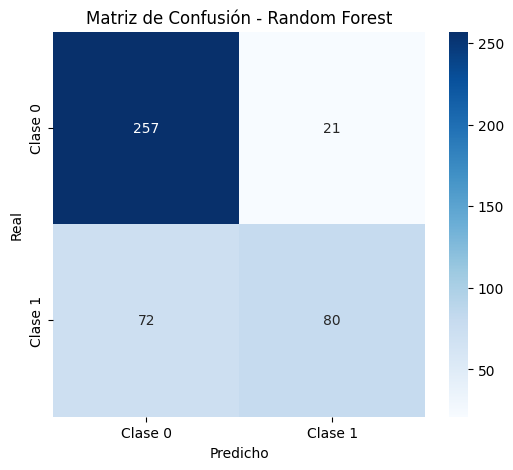

In [31]:
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    print(f"{name} - F1 Score: {f1_score(y_test, y_pred)}")

    plot_confusion_matrix(y_test, y_pred, name)


**Mejores hiperparámetros**

Usar las features de PCA con los mejores hiperparámetros que se habían obtenido.

c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


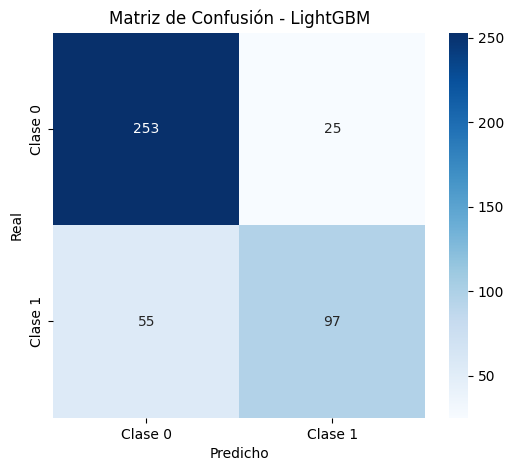

XGBoost - F1 Score: 0.6886


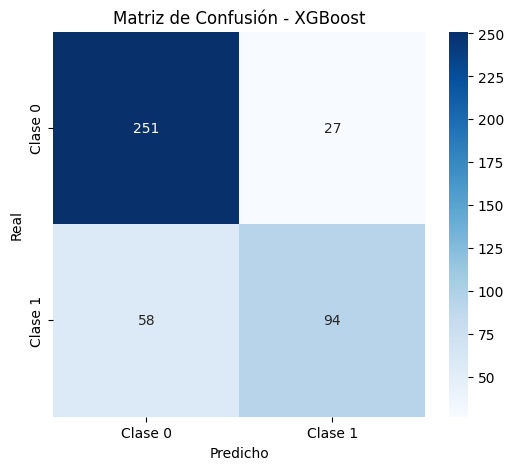

Random Forest - F1 Score: 0.6770


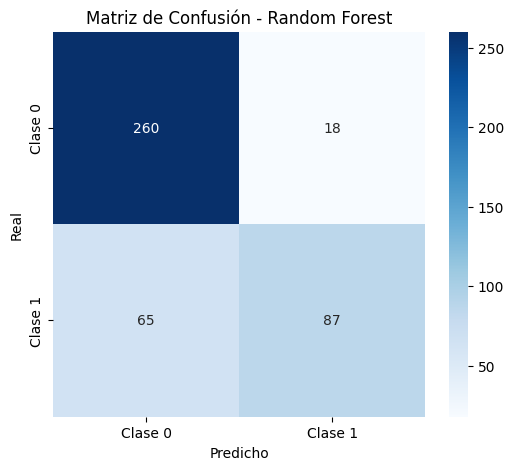

In [ ]:
for name, model in best_models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    
    print(f"{name} - F1 Score: {f1_score(y_test, y_pred)}")
    
    plot_confusion_matrix(y_test, y_pred, name)

#### 8. Deep Learning

**Redes neuronales**

Aunque el proceso de ML da buenos resultados, probar con DL.

c:\Users\tebar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6463 - loss: 0.6427 - val_accuracy: 0.7791 - val_loss: 0.5137
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7719 - loss: 0.4960 - val_accuracy: 0.8233 - val_loss: 0.4300
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7907 - loss: 0.4624 - val_accuracy: 0.8349 - val_loss: 0.3996
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8288 - loss: 0.4090 - val_accuracy: 0.8419 - val_loss: 0.3907
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8371 - loss: 0.3853 - val_accuracy: 0.8349 - val_loss: 0.3945
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8415 - loss: 0.3616 - val_accuracy: 0.8419 - val_loss: 0.3893
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8536 - loss: 0.3427 - val_accuracy: 0.8395 - val_loss: 0.3848
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8619 - loss: 0.3297 - val_accuracy: 0.8419 - val_l

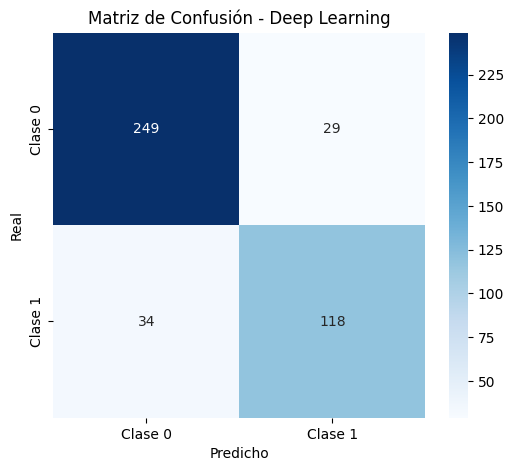

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


# Definir el modelo de red neuronal
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta 1
    Dropout(0.3),  # Regularización para evitar sobreajuste
    Dense(64, activation='relu'),  # Capa oculta 2
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar la red neuronal
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluar el modelo en el conjunto de prueba
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")

# Imprimir F1 Score
print(f"Deep Learning Model - F1 Score: {f1_score(y_test, y_pred_nn)}")

# Mostrar matriz de confusión
plot_confusion_matrix(y_test, y_pred_nn, "Deep Learning")


Aunque da buenos resultados, no es mejor que ML y además son modelos más complejos, por lo que no hay necesidad de profundizar por esta rama.

Los hiperparámetros en validación bajaron el F1-score (91.13), pero en test final mejoró (93.33).
* Posible razón: La validación cruzada puede haber afectado la evaluación del modelo, pero al probarlo en test final, los hiperparámetros fueron efectivos. Esto indica que el modelo generaliza bien.

La selección de features con Random Forest no mejoró el resultado (sigue en 93.33), pero tampoco lo empeoró.
* Conclusión: Puede ser que el modelo original ya estuviera usando las features más relevantes y la selección no tuvo un impacto significativo.

El mejor resultado (93.33) se obtiene con hiperparámetros bien ajustados, con o sin selección de features.
* Conclusión: Optimizar hiperparámetros es más relevante que reducir el número de variables en este caso. La selección de features no ayudó, pero tampoco perjudicó.

Tu modelo es estable y robusto, ya que los resultados no varían mucho.
* Esto es bueno porque significa que el modelo no está sobreajustando (overfitting) y generaliza bien en datos nuevos.